In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Initialize session
sess = tf.Session()

/Users/jacob/anaconda3/envs/kiromic/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# Load data
mcycle = pd.read_csv('mcycle',delimiter='\t')
mcycle.times = (mcycle.times - mcycle.times.mean())/mcycle.times.std()
mcycle.accel = (mcycle.accel - mcycle.accel.mean())/mcycle.accel.std()

# Reshape to input format for network
times = np.expand_dims(mcycle.times.values, 1)
accel = np.expand_dims(mcycle.accel.values, 1)

In [32]:
# Create network
class q_model:
    def __init__(self, 
                 sess, 
                 quantiles, 
                 in_shape=1, 
                 out_shape=1, 
                 batch_size=32):
        
        self.sess = sess
        
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        
        self.in_shape = in_shape
        self.out_shape = out_shape
        self.batch_size = batch_size
        
        self.outputs = []
        self.losses = []
        self.loss_history = []
        
        self.build_model()
        
    def build_model(self, scope='q_model', reuse=tf.AUTO_REUSE): 
        with tf.variable_scope(scope, reuse=reuse) as scope:
            self.x = tf.placeholder(tf.float32, shape=(None, self.in_shape))
            self.y = tf.placeholder(tf.float32, shape=(None, self.out_shape))

            self.layer0 = tf.layers.dense(self.x, 
                                    units=32, 
                                    activation=tf.nn.relu)
            self.layer1 = tf.layers.dense(self.layer0, 
                                    units=32, 
                                    activation=tf.nn.relu)

            # Create outputs and losses for all quantiles
            for i in range(self.num_quantiles):
                q = self.quantiles[i]
                
                # Get output layers 
                output = tf.layers.dense(self.layer1, 1, name="{}_q{}".format(i, int(q*100)))
                self.outputs.append(output)
                
                # Create losses
                
                error = tf.subtract(self.y, output)
                loss = tf.reduce_mean(tf.maximum(q*error, (q-1)*error), axis=-1)

                self.losses.append(loss)

            # Create combined loss
            self.combined_loss = tf.reduce_mean(tf.add_n(self.losses))
            self.train_step = tf.train.AdamOptimizer().minimize(self.combined_loss)

    def fit(self, x, y, epochs=100):  
        for epoch in range(epochs):
            epoch_losses = []
            for idx in range(0, x.shape[0], self.batch_size):
                batch_x = x[idx : min(idx + self.batch_size, x.shape[0]),:]
                batch_y = y[idx : min(idx + self.batch_size, y.shape[0]),:]

                feed_dict = {self.x: batch_x,
                             self.y: batch_y}

                _, c_loss = self.sess.run([self.train_step, self.combined_loss], feed_dict)
                epoch_losses.append(c_loss)
                
            epoch_loss =  np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            if epoch % 10 == 0:
                print(epoch_loss)
            
    def predict(self, x):   
        # Run model to get outputs
        feed_dict = {self.x: x}
        predictions = sess.run(self.outputs, feed_dict)
        
        return predictions


In [34]:
# Instantiate model
quantiles = [.1, .5, .9]
model = q_model(sess, quantiles, batch_size=32)

# Initialize all variables
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [35]:
# Run training
epochs = 2000
model.fit(times, accel, epochs)

1.0642648
1.0244757
0.98936397
0.95965743
0.93704027
0.9184456
0.904129
0.8928612
0.8825379
0.8736808
0.86603075
0.85911894
0.8534596
0.84812754
0.842951
0.8379082
0.8329573
0.8280298
0.8230159
0.8178821
0.8127601
0.8081052
0.8033833
0.7989955
0.7946299
0.79049355
0.7863474
0.78231025
0.7782083
0.7740867
0.7699724
0.76574427
0.76139456
0.75714654
0.75291616
0.74826384
0.7433756
0.73869747
0.7341592
0.7294057
0.72447014
0.719779
0.7150578
0.7104675
0.705935
0.7015936
0.69755524
0.693487
0.68959904
0.6857021
0.6819152
0.6778431
0.6738437
0.669707
0.66580105
0.6619098
0.65791315
0.65392697
0.6498747
0.6457342
0.64145595
0.6374223
0.6336871
0.6301946
0.6266
0.62303
0.61970776
0.6161633
0.6127231
0.60915637
0.60569465
0.60254145
0.5993519
0.59621626
0.59320253
0.59013385
0.58698833
0.58394635
0.5812109
0.57855636
0.5760695
0.57348895
0.5709732
0.56861323
0.5664015
0.56425786
0.5621554
0.5600886
0.5579452
0.55590266
0.5537462
0.5516081
0.54945916
0.5473327
0.54539806
0.5433923
0.5414339
0.53

0.26452982
0.26262584
0.2629045
0.26253518
0.2624204
0.262038
0.26242724
0.26227918
0.26248267
0.26230365
0.26238295
0.26193032
0.26308236
0.2626797
0.2619071
0.2623317
0.26232207
0.2625792
0.2621431
0.26177707
0.26218805
0.26224068
0.26182145
0.26161686
0.26162288
0.2620734
0.26163158
0.2618505
0.2637072
0.2630597
0.26238146
0.26280448
0.26383272
0.26436177
0.2636102
0.2629314
0.26320094
0.2624835
0.2626593
0.2627803
0.26148978
0.262108
0.26114985
0.2623075
0.26201352
0.2616273
0.26259366
0.26212433
0.26179388
0.26313356
0.26290143
0.26167
0.26303717
0.26285243
0.26360342
0.26157817
0.2626327
0.261974
0.26240876
0.26149866
0.26325634
0.26245546
0.26248938
0.26188776
0.26110688
0.26215693
0.26123413
0.26047918
0.26063403
0.26077017
0.26073712
0.26010504
0.26053676
0.259908
0.25989708
0.2605647
0.2601026
0.25993648
0.25950518
0.26031676
0.25964323
0.26098943
0.25994954
0.2598513
0.25979924
0.259582
0.2595745
0.2602765
0.26053658
0.259701
0.26041153
0.26072958
0.26007876
0.2600465
0.2593

0.24596061
0.24549167
0.24530458
0.24535894
0.24306916
0.24648915
0.24543352
0.24292774
0.24477972
0.24609248
0.24316339
0.24596958
0.24414115
0.24321504
0.24306905
0.24316858
0.24251306
0.24251215
0.24250562
0.24310243
0.24243748
0.2422399
0.24216278
0.24251957
0.24280243
0.24230999
0.24366044
0.24315624
0.24412863
0.24650355
0.2427408
0.24495967
0.24537326
0.24340315
0.24286778
0.24386685
0.24271376
0.2439306
0.24438691
0.2429129
0.24372537
0.24406736
0.24408223
0.24415086
0.24375701
0.24250214
0.24277885
0.24205
0.24280322
0.24333565
0.24254517
0.24195528
0.24156399
0.24195038
0.24203195
0.24304931
0.24396288
0.24160881
0.24277155
0.2419316
0.2419831
0.2426049
0.24389596
0.24233906
0.24282603
0.24436426
0.24201454
0.24517222
0.24301165
0.24204911
0.24299593
0.24273331
0.24197544
0.24159734
0.24359123
0.24437882
0.24138175
0.24480851
0.2424826
0.24287565
0.24532987
0.2419191
0.24475837
0.24361467
0.2421825
0.24480028
0.24457097
0.24267828
0.24230559
0.24536176
0.24256814
0.24391352
0

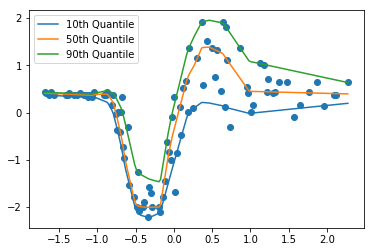

In [38]:
# Generate the range of data we'd like to predict
test_times = np.expand_dims(np.linspace(times.min(),times.max(),200), 1)
predictions = model.predict(test_times)

plt.scatter(times, accel)
for i, prediction in enumerate(predictions):
    plt.plot(test_times, prediction, label='{}th Quantile'.format(int(model.quantiles[i]*100)))
    
plt.legend()
plt.show()

In [27]:
model.outputs

[<tf.Tensor 'q_model_5/0_q10/BiasAdd:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'q_model_5/1_q50/BiasAdd:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'q_model_5/2_q90/BiasAdd:0' shape=(?, 1) dtype=float32>]